In [1]:

import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import numpy as np
import plotly.express as px
import datetime
import warnings
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# Load in weather dataset and guest dataset
weather_data = pd.read_csv('data/raw/archive.csv')
data = pd.read_csv('data/processed/guests_resort.csv')

data['arrival_date'] = pd.to_datetime(data['arrival_date'])
#weather_data.head(5)
data.head(5)

,arrival_date,total_guests
0,2015-07-01,73
1,2015-07-02,94
2,2015-07-03,88
3,2015-07-04,107
4,2015-07-05,98


In [4]:
from sklearn import preprocessing

# Join weather and guest count datasets
data['w_code'] = weather_data['weathercode (wmo code)'].astype(int).copy()
data['temp'] = weather_data['apparent_temperature_mean (°C)'].astype(float).copy()
data['precip_hours'] = weather_data['precipitation_hours (h)'].astype(float).copy()
data['precip_sum'] = weather_data['precipitation_sum (mm)'].astype(float).copy()
data['day'] = data['arrival_date'].dt.day.astype(int)
data['month'] = data['arrival_date'].dt.month.astype(int)
data['year'] = data['arrival_date'].dt.year.astype(int)

# Flag holiday as true or false
# based on total list of holiday dates
min_max_scaler = preprocessing.MinMaxScaler()
data = data[['total_guests', 'temp', 'precip_sum', 'precip_hours', 'day', 'month', 'year', 'arrival_date']]


data.head(5)

,total_guests,temp,precip_sum,precip_hours,day,month,year,arrival_date
0,73,20.1,0.1,1.0,1,7,2015,2015-07-01
1,94,19.5,0.0,0.0,2,7,2015,2015-07-02
2,88,19.6,0.0,0.0,3,7,2015,2015-07-03
3,107,23.1,0.0,0.0,4,7,2015,2015-07-04
4,98,19.3,0.0,0.0,5,7,2015,2015-07-05


In [5]:
holiday_ranges = [
    #christmas 2015 to christmas 2016
    [pd.to_datetime('2015-12-18'), pd.to_datetime('2016-01-03')], # Christmas 2015
    [pd.to_datetime('2016-02-08'), pd.to_datetime('2016-02-10')], # Shrove 2016
    [pd.to_datetime('2016-03-21'), pd.to_datetime('2016-04-01')], # Easter 2016
    [pd.to_datetime('2016-07-09'), pd.to_datetime('2016-09-16')], # Summer holiday 2016
    [pd.to_datetime('2016-12-19'), pd.to_datetime('2017-01-02')], # Christmas 2016
    [pd.to_datetime('2017-02-27'), pd.to_datetime('2017-03-01')], # Shrove 2017
    [pd.to_datetime('2017-04-05'), pd.to_datetime('2017-04-18')], # Easter 2017
    [pd.to_datetime('2017-06-23'), pd.to_datetime('2017-09-23')], # Summer holiday 2017
]


# Given an array with date ranges, unpack all
# dates inbetween (inclusive) and return the total list
# of dates so that they can be flagged later
def ranges_to_dates(range_array):
    dates = []
    for elem in range_array:
        date_range = pd.date_range(start=elem[0], end=elem[1], freq='D')
        dates.extend(date_range.tolist())
    return dates

mean_guests = round(data['total_guests'].mean()) # Mean amount of guests

dates = pd.Series(data['arrival_date']) 
holidays = ranges_to_dates(holiday_ranges)

# Create rolling mean (mean of last n items) and place in column
rolling_mean_7 = data['total_guests'].shift(1).rolling(window=7).mean()
rolling_mean_28 = data['total_guests'].shift(1).rolling(window=28).mean()

# Feature engineering
data['holiday_flag'] = data['arrival_date'].isin(holidays).map({True: 1, False: 0}) # make holidays a list
data['is_weekend'] = data['arrival_date'].dt.dayofweek.isin([4,5,6]).map({True: 1, False: 0})
data['is_weekday'] = data['arrival_date'].dt.dayofweek.isin([1,2,3]).map({True: 1, False: 0})
data['yesterday'] = data['total_guests'].shift(1).copy(deep=True) # Yesterday's demand
data['last_7_days'] = rolling_mean_7
data['last_28_days'] = rolling_mean_28

data.loc[0, 'yesterday'] = mean_guests # First 'yesterday'  elem is empty, set to mean
data.loc[0:6, 'last_7_days'] = mean_guests # First week is empty, set to mean
data.loc[0:27, 'last_28_days'] = mean_guests # First week is empty, set to mean

# Sanity check - did we recognise as many holidays
# as the amount of holidays we put into the sys?
holiday_count = data['holiday_flag'].sum()
print("Recognised {} holidays. Mean guests over entire dataset: {}".format(holiday_count, mean_guests))

data.head(25)
# data.to_csv('data/final/data.csv') 

Recognised 204 holidays. Mean guests over entire dataset: 99


,total_guests,temp,precip_sum,precip_hours,day,month,year,arrival_date,holiday_flag,is_weekend,is_weekday,yesterday,last_7_days,last_28_days
0,73,20.1,0.1,1.0,1,7,2015,2015-07-01,0,0,1,99.0,99.000000,99.0
1,94,19.5,0.0,0.0,2,7,2015,2015-07-02,0,0,1,73.0,99.000000,99.0
2,88,19.6,0.0,0.0,3,7,2015,2015-07-03,0,1,0,94.0,99.000000,99.0
3,107,23.1,0.0,0.0,4,7,2015,2015-07-04,0,1,0,88.0,99.000000,99.0
4,98,19.3,0.0,0.0,5,7,2015,2015-07-05,0,1,0,107.0,99.000000,99.0
5,89,20.5,0.0,0.0,6,7,2015,2015-07-06,0,0,0,98.0,99.000000,99.0
6,75,20.8,0.0,0.0,7,7,2015,2015-07-07,0,0,1,89.0,99.000000,99.0
7,60,20.4,0.0,0.0,8,7,2015,2015-07-08,0,0,1,75.0,89.142857,99.0
8,73,21.6,0.0,0.0,9,7,2015,2015-07-09,0,0,1,60.0,87.285714,99.0
9,90,19.2,0.0,0.0,10,7,2015,2015-07-10,0,1,0,73.0,84.285714,99.0


# Some EDA

In [6]:

start = pd.to_datetime('2016-07-01') # Exactly one year after first entry
end = pd.to_datetime('2017-07-01') # Exactly two year after first entry

arrival_dates = pd.Series(data['arrival_date']) # Convert to series

# Holds all entries of first year of data
subset_before = data[arrival_dates < start] 
subset_before = subset_before.reset_index(drop=True)

# Holds all entries of second year of data
subset_after = data[arrival_dates >= start] 
subset_after = subset_after[arrival_dates <= end] 
subset_after = subset_after.reset_index(drop=True)

# Assign guest counts of previous year to current year
subset_after['prev_yr'] = round(subset_before['total_guests'].copy(), 0)

# We are left with a year of guest data that also contains
# the amount of guests in the previous year
subset_after.head(5)

c:\Users\frans\miniconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == "":


,total_guests,temp,precip_sum,precip_hours,day,month,year,arrival_date,holiday_flag,is_weekend,is_weekday,yesterday,last_7_days,last_28_days,prev_yr
0,76,18.2,0.0,0.0,1,7,2016,2016-07-01,0,1,0,106.0,83.285714,90.392857,73
1,115,18.8,0.0,0.0,2,7,2016,2016-07-02,0,1,0,76.0,87.428571,88.964286,94
2,72,24.3,0.0,0.0,3,7,2016,2016-07-03,0,1,0,115.0,83.571429,89.785714,88
3,123,24.6,0.0,0.0,4,7,2016,2016-07-04,0,0,0,72.0,78.285714,89.000000,107
4,80,24.0,0.0,0.0,5,7,2016,2016-07-05,0,0,1,123.0,84.857143,89.928571,98


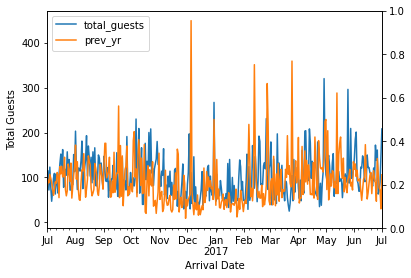

Guests prev year: 33422, guests current year: 37075


In [7]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

subset_after.plot(x='arrival_date', y=['total_guests', 'prev_yr'], ax=ax1)
ax1.set_xlabel('Arrival Date')
ax1.set_ylabel('Total Guests')
ax1.legend(loc='upper left')
plt.show()

guests_cur = subset_after['total_guests'].sum()
guests_prev = subset_before['total_guests'].sum()

print("Guests prev year: {}, guests current year: {}".format(guests_prev, guests_cur))
dif = guests_cur/guests_prev


In [8]:
# Preprocessen data

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import preprocessing

tf.random.set_seed(7)
x = data.drop(['arrival_date', 'month', 'total_guests', 'day', 'precip_sum', 'year'], axis=1) # Drop columns we will not be using
y = data['total_guests']
x = x.reset_index(drop=True)
y = y.reset_index(drop=True)
correlations = x.corrwith(y)
print(correlations)

print(x.shape, y.shape)


correlations.to_csv('data/final/correlations.csv') 
x.head()

temp            0.221293
precip_hours    0.008913
holiday_flag    0.204835
is_weekend      0.150656
is_weekday     -0.198556
yesterday       0.227029
last_7_days     0.323177
last_28_days    0.311328
dtype: float64
(793, 8) (793,)


,temp,precip_hours,holiday_flag,is_weekend,is_weekday,yesterday,last_7_days,last_28_days
0,20.1,1.0,0,0,1,99.0,99.0,99.0
1,19.5,0.0,0,0,1,73.0,99.0,99.0
2,19.6,0.0,0,1,0,94.0,99.0,99.0
3,23.1,0.0,0,1,0,88.0,99.0,99.0
4,19.3,0.0,0,1,0,107.0,99.0,99.0


In [10]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)


# LSTM Result 

In [13]:
# LSTM Network
look_back = 2
def build_and_compile_LSTM():
  model = keras.Sequential()
  model.add(layers.LSTM(16, input_shape=(look_back, 8)))
  model.add(layers.Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [14]:
# Build the LSTM model
lstm_model = build_and_compile_LSTM()
lstm_model.summary()

scaler = MinMaxScaler(feature_range=(0, 1))
x_scaled = scaler.fit_transform(x)

x_transformed = []
y_transformed = []

# Generate input sequences and corresponding outputs
for i in range(len(x_scaled) - look_back):
    x_transformed.append(x_scaled[i:i+look_back])
    y_transformed.append(y[i+look_back])
    
# Convert the lists to NumPy arrays
x_transformed = np.array(x_transformed)
y_transformed = np.array(y_transformed)


x_train_lstm, x_test_lstm, y_train_lstm, y_test_lstm = train_test_split(x_transformed,y_transformed, test_size=0.15, shuffle=False)
print(y_transformed.shape)

history = lstm_model.fit(x_train_lstm,y_train_lstm, validation_split=0.10, batch_size=8, verbose=0, epochs=400)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 16)                1600      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,617
Trainable params: 1,617
Non-trainable params: 0
_________________________________________________________________
(791,)


4/4 [==============================] - 1s 5ms/step
(119,) (119, 1)
R-squared: 0.13
MSE: 1280.68


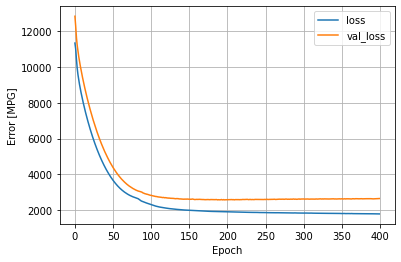

In [15]:

pred = lstm_model.predict(x_test_lstm)
print(y_test_lstm.shape, pred.shape)
r2 = r2_score(y_test_lstm, pred)
mse = mean_squared_error(y_test_lstm, pred)
print(f"R-squared: {r2:.2f}")
print(f"MSE: {mse:.2f}")
plot_loss(history)

# Neural network results

In [16]:
from sklearn.svm import SVR

def build_DNN_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dropout(rate=0.5),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

Train samples: 634 and test samples 159
25.803897857666016
5/5 [==============================] - 0s 4ms/step
R-squared: 0.36
MSE: 1177.83


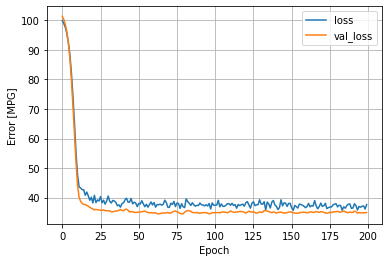

In [17]:


# scaler = MinMaxScaler(feature_range=(0, 1))
# x_scaled = scaler.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)

# Normaliser used for regular NN
normalizer = tf.keras.layers.Normalization()
normalizer.adapt(np.array(x_train))

dnn_model = build_DNN_model(normalizer)
# dnn_model.summary()

print("Train samples: {} and test samples {}".format(len(x_train), len(x_test)))

history = dnn_model.fit(x_train,y_train,validation_split=0.1, verbose=0, epochs=200)
score = dnn_model.evaluate(x_test, y_test,verbose=0)
print(score)    
plot_loss(history)

pred = dnn_model.predict(x_test)
result = pd.DataFrame(index=range(len(pred)), columns=['pred', 'ans'])
result['pred'] = pred
result['ans'] = y_test

r2 = r2_score(y_test, pred)
mse = mean_squared_error(y_test, pred)
print(f"R-squared: {r2:.2f}")
print(f"MSE: {mse:.2f}")

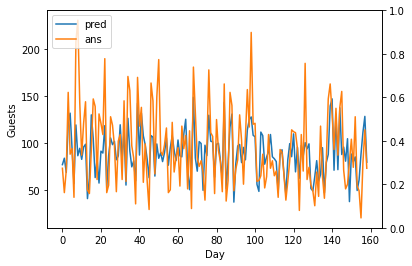

,pred,ans
0,76.884140,73
1,83.743973,47
2,68.646858,71
3,121.157730,154
4,131.832535,88
5,94.013466,94
6,56.708961,42
7,119.248512,208
8,86.388870,231
9,94.312157,143


In [18]:


fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

result.plot(y=['pred', 'ans'], ax=ax1)
ax1.set_xlabel('Day')
ax1.set_ylabel('Guests')
ax1.legend(loc='upper left')
plt.show()
result.head(10)

# SVR Model

In [19]:
from sklearn.svm import SVR

scaler = MinMaxScaler(feature_range=(0, 1))
x_scaled = scaler.fit_transform(x)

x_train_SVR, x_test_SVR, y_train_SVR, y_test_SVR = train_test_split(x_scaled, y, test_size=0.15, random_state=1, shuffle=True)
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_model.fit(x_train_SVR, y_train_SVR)

# Make predictions on the test set
pred = svr_model.predict(x_test_SVR)
mse = mean_squared_error(y_test_SVR, pred)
r2 = r2_score(y_test_SVR, pred)

# Print the evaluation results
print(f"MSE: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

MSE: 1451.60
R-squared: 0.24
